In [1]:
!pip install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, Concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle5 as pickle
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

# mfcc 불러오기

In [7]:
with open("/content/drive/MyDrive/멀캠_2nd_semiproject/데이터/mfcc/mfcc_1565_data.pickle", "rb") as f:
    data = pickle.load(f)
length=[]
for i in range(len(data)):
    length.append(data[i].shape[1])
    
min_len=min(length)

result=[]
for i in range(len(data)):
    result.append(data[i][:,:min_len])
    
result_data=np.array(result)
result_data.shape

(2304, 30, 901)

## covid19 여부 불러오기



In [8]:
y=pd.read_csv("/content/drive/MyDrive/멀캠_2nd_semiproject/데이터/mfcc/Y_data_1516.csv")
y=np.array(y.iloc[:,0].values)

## feature 불러오기

In [14]:
features = pd.read_csv("/content/drive/MyDrive/멀캠_2nd_semiproject/데이터/csv파일/train_df_최종본_15세이상_65세미만.csv")
features = features.iloc[:,[4,5,6,7]]
feature_lst = []
for i in features.index:
    for _ in range(4):
        feature_lst.append(features.iloc[i,:].values)
features = pd.DataFrame(feature_lst)
features.shape

(2304, 4)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(
    result_data, features, stratify = features, test_size = 0.2
)

In [16]:
features_train = Y_train.iloc[:,:-1].values
y_data_train = Y_train.iloc[:,-1].values

In [17]:
features_test = Y_test.iloc[:,:-1].values
y_data_test = Y_test.iloc[:,-1].values

In [18]:
# 각 입력에 대한 형태를 명시
img_input = Input(shape = (30,901,1), name = "features_train")
form_input = Input(shape = (3,), name = "y_data_train")

In [19]:
# 이미지 입력
x_1 = Conv2D(32, (3,3), activation = "relu")(img_input)
x_1 = Conv2D(32, (3,3), activation = "relu")(x_1)
x_1 = MaxPooling2D(strides = 2)(x_1)
x_1 = Dropout(0.25)(x_1)
x_1 = GlobalAveragePooling2D()(x_1)

# 피쳐 입력
x_2 = Dense(128, input_dim = 3 ,activation  = "relu")(form_input)
x_2 = Dense(32, activation = "relu")(form_input)

In [20]:
# 출력을 만들기 위해 모든 입력을 하나의 텐서로 합침
x = Concatenate()([x_1, x_2])

In [21]:
rate_pred = Dense(1, name = "covid", activation = "sigmoid")(x)

In [22]:
model = Model(inputs = [img_input, form_input],
              outputs = [rate_pred])

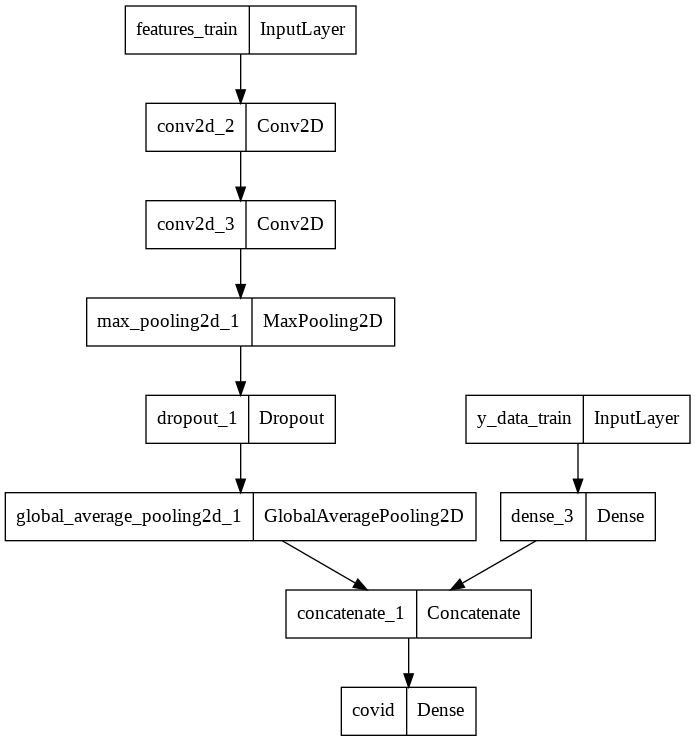

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 features_train (InputLayer)    [(None, 30, 901, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 28, 899, 32)  320         ['features_train[0][0]']         
                                                                                                  
 conv2d_3 (Conv2D)              (None, 26, 897, 32)  9248        ['conv2d_2[0][0]']               
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 13, 448, 32)  0          ['conv2d_3[0][0]']           

In [25]:
model.compile(optimizer = "adam",
              loss = "binary_crossentropy", metrics = ["accuracy"])

In [26]:
model_path = "functional-other.h5"
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1, monitor = "val_accuracy")
es = EarlyStopping(patience=10, monitor = "val_accuracy")

In [27]:
hist = model.fit([X_train, features_train] , y_data_train,
                 epochs = 100, batch_size = 100,
                 validation_split=0.2, callbacks = [es, mc])

Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 0.7357 - accuracy: 0.5156
Epoch 1: val_accuracy improved from -inf to 0.47154, saving model to functional-other.h5
15/15 [==============================] - 7s 212ms/step - loss: 0.7357 - accuracy: 0.5156 - val_loss: 0.7035 - val_accuracy: 0.4715
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 0.6874 - accuracy: 0.5543
Epoch 2: val_accuracy improved from 0.47154 to 0.53930, saving model to functional-other.h5
15/15 [==============================] - 2s 118ms/step - loss: 0.6874 - accuracy: 0.5543 - val_loss: 0.6877 - val_accuracy: 0.5393
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 0.6862 - accuracy: 0.5488
Epoch 3: val_accuracy improved from 0.53930 to 0.60163, saving model to functional-other.h5
15/15 [==============================] - 2s 123ms/step - loss: 0.6862 - accuracy: 0.5488 - val_loss: 0.6766 - val_accuracy: 0.6016
Epoch 4/100
15/15 [==============================

In [30]:
model = load_model(model_path)
model.evaluate([X_test, features_test], y_data_test)

15/15 [==============================] - 1s 18ms/step - loss: 0.6620 - accuracy: 0.5944


[0.6619836091995239, 0.5943601131439209]

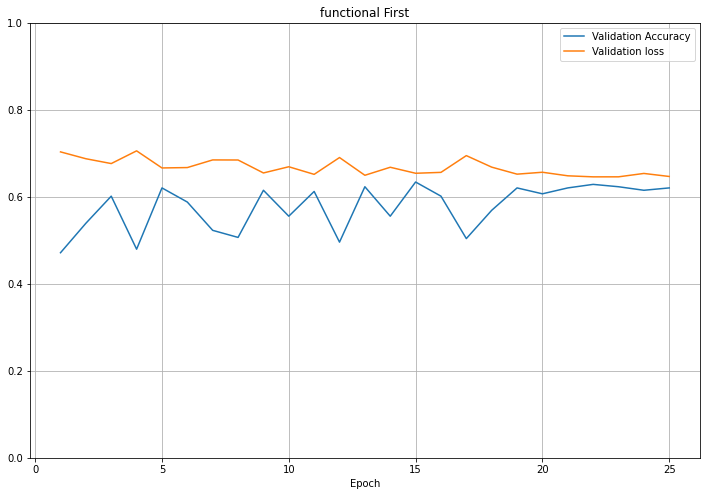

In [31]:
y_acc = hist.history["val_accuracy"]
y_vloss = hist.history["val_loss"]
xs = np.arange(1, len(y_acc) + 1)

plt.figure(figsize = (12,8))
plt.plot(xs, y_acc, label = "Validation Accuracy")
plt.plot(xs, y_vloss, label = "Validation loss")
plt.legend(), plt.grid(), plt.xlabel("Epoch"), plt.title("functional First"), plt.ylim([0,1])
plt.show()

In [32]:
from sklearn.metrics import confusion_matrix
y_train_pred=model.predict([X_test, features_test])
yhat=[]
for data in y_train_pred:
  if data>=0.5:
    yhat.append(1)
  else:
    yhat.append(0)


In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score
p = precision_score(y_data_test, yhat)
print(p)
r = recall_score(y_data_test, yhat)
print(r)
f1 = f1_score(y_data_test, yhat)
print(f1)

0.6964285714285714
0.33766233766233766
0.45481049562682213


### train_test dataset에 없는 다른 데이터로 모델 테스트(with augmentation)

In [28]:
with open("/content/drive/MyDrive/멀캠_2nd_semiproject/데이터/test/aug/test_mfcc_15세65세_aug.pickle", "rb") as f:
    data = pickle.load(f)
length=[]
for i in range(len(data)):
    length.append(data[i].shape[1])
    
min_len=min(length)

result=[]
for i in range(len(data)):
    result.append(data[i][:,:min_len])
    
result_data_other=np.array(result)
result_data_other.shape

(2080, 30, 901)

In [29]:
features_other = pd.read_csv("/content/drive/MyDrive/멀캠_2nd_semiproject/데이터/test/aug/test_df_15세56세_aug.csv")
features_other = features_other.iloc[:,[4,5,6,7]]
features_other

,man,respiratory_condition,fever_muscle_pain,COVID-19
0,1,1,0,0
1,1,1,0,0
2,1,1,0,0
3,1,1,0,0
4,1,1,0,0
...,...,...,...,...
2075,0,0,1,1
2076,0,0,1,1
2077,0,0,1,1
2078,0,0,1,1


In [34]:
feature_test_data = features_other.iloc[:,:-1].values
y_test_data = features_other.iloc[:,-1].values

In [53]:
yhat_test=[]
for i in range( int(len(y_test_data)/5) ):
  y_train_pred=[]

  for cnt in range( (i-1)*5, i*5):
    y_train_pred.append( model.predict( [ result_data_other[cnt].reshape(1,30,-1), feature_test_data[cnt].reshape(1,3) ] ) )

  y_hat= np.mean(y_train_pred)
  if y_hat>=0.5:
    yhat_test.append(1)
  else:
    yhat_test.append(0)


In [55]:
y_real=[]
for i in range( int(len(y_test_data)/5) ):
  y=[]
  for cnt in range( (i-1)*5, i*5):
    y.append(y_test_data[cnt])
  y_real.append(int(np.mean(y)) )


In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
p = precision_score(y_real, yhat_test)
print(p)
r = recall_score(y_real, yhat_test)
print(r)
f1 = f1_score(y_real, yhat_test)
print(f1)
s=accuracy_score(y_real, yhat_test)
print(s)

0.7340425531914894
0.3317307692307692
0.456953642384106
0.6057692307692307


### train_test dataset에 없는 다른 데이터로 모델 테스트(without augmentation)

In [61]:
with open("/content/drive/MyDrive/멀캠_2nd_semiproject/데이터/test/fffff.pickle", "rb") as f:
    data = pickle.load(f)
length=[]
for i in range(len(data)):
    length.append(data[i].shape[1])
    
min_len=min(length)

result=[]
for i in range(len(data)):
    result.append(data[i][:,:min_len])
    
result_data_other=np.array(result)
result_data_other.shape

(520, 30, 901)

In [62]:
features_other = pd.read_csv("/content/drive/MyDrive/멀캠_2nd_semiproject/데이터/test/test_df_15세65세_aug전.csv")
features_other = features_other.iloc[:,[4,5,6,7]]
features_other.shape

(520, 4)

In [63]:
feature_test_data = features_other.iloc[:,:-1].values
y_test_data = features_other.iloc[:,-1].values

In [66]:
yhat_test=[]

y_train_pred=model.predict( [result_data_other, feature_test_data ] )

for data in y_train_pred:
  if data>=0.5:
    yhat_test.append(1)
  else:
    yhat_test.append(0)

In [67]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
p = precision_score(y_test_data, yhat_test)
print(p)
r = recall_score(y_test_data, yhat_test)
print(r)
f1 = f1_score(y_test_data, yhat_test)
print(f1)
s=accuracy_score(y_test_data, yhat_test)
print(s)

0.6551724137931034
0.36538461538461536
0.4691358024691357
0.5865384615384616
